In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from IMNN import IMNN
from IMNN.ABC import ABC
from make_data import GenerateGaussianNoise
tfd = tfp.distributions

print("TensorFlow {}\nTensorFlow Probability {}\nIMNN {}\nnumpy {}".format(
    tf.__version__, tfp.__version__, IMNN.__version__, np.__version__))

TensorFlow 2.1.0
TensorFlow Probability 0.9.0
IMNN 0.2a4
numpy 1.18.2


# Summarising the mean and the variance

For this example we are going see how the IMNN can summarise the unknown mean, $\mu$, and variance, $\Sigma$, of $n_{\bf d}=10$ data points of a 1D random Gaussian field, ${\bf d}=\{d_i\sim\mathcal{N}(\mu,\Sigma)|i\in[1, n_{\bf d}]\}$. This is an interesting problem since we know the likelihood analytically, but it is non-Gaussian
$$\mathcal{L}({\bf d}|\mu,\Sigma) = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$
We can therefore use this example to compare our method using the IMNN to the ideal.

Simulations from this model can be made using

In [3]:
def simulator(x, seed=None, simulator_args=None):
    if seed is not None:
        np.random.seed(seed)
    return np.moveaxis(
        np.random.normal(
            x[:, 0], 
            np.sqrt(x[:, 1]), 
            simulator_args["input_shape"] + (x.shape[0],)), 
        -1, 0)

And the likelihood evaluated for any given observation using

In [4]:
class AnalyticLikelihood():
    def __init__(self, data):
        if len(data.shape) == 1:
            data = data[np.newaxis, :]
        self.data = data
        
    def check_grid(self, grid):
        if len(grid.shape) == 1:
            parameters = grid[np.newaxis, :]
        elif len(grid.shape) == 2:
            parameters = grid.T
        else:
            parameters = grid.reshape((2, -1)).T
        return parameters, grid[0].shape
        
    def log_prob(self, grid, shape):
        if len(grid.shape) == 1:
            grid = grid[np.newaxis, ...]
        sq_diff = (self.data[..., np.newaxis] - grid[:, 0])**2.
        exp = np.sum(-0.5 * sq_diff / grid[:, 1], axis=1)
        norm = -(self.data.shape[1] / 2.) * np.log(2. * np.pi * grid[:, 1])[np.newaxis, ...]
        log_prob = np.reshape(exp + norm, ((-1,) + shape))
        return log_prob
        
    def prob(self, grid, shape):
        return np.exp(self.log_prob(grid, shape))
    
    def log_posterior(self, grid, shape, prior):
        likelihood_eval = self.log_prob(grid, shape)
        prior_eval = np.reshape(prior.log_prob(grid), ((-1,) + shape))
        return prior_eval + likelihood_eval
    
    def posterior(self, grid, shape, prior):
        return np.exp(self.log_posterior(grid, shape, prior))

Lets observe some data generated from a Gaussian distribution with a mean, $\mu=3$, and a variance $\Sigma=2$ - we're going to generate the data from seed 37 (for no particular reason). Once this is generated we're going to forget that we ever knew this.

In [5]:
θ_target = np.array([3., 2.])
target_data = simulator(θ_target[np.newaxis, :],
                        seed=37, 
                        simulator_args={"input_shape": (10,)})

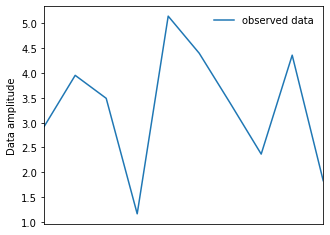

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (5, 4))
ax.plot(target_data.T, 
        label="observed data")
ax.legend(frameon = False)
ax.set_xlim([0, 9])
ax.set_xticks([])
ax.set_ylabel("Data amplitude");

## Inferring the mean and variance

For the inference we start by defining our prior as a uniform distribution. This distribution can be a TensorFlow Probability distribution for simplicity. We are going to choose the prior to be uniform from -10 to 10 for the mean and 0 to 10 for the variance.

$$p(\mu,\Sigma)=\textrm{Uniform}\left[\textrm{lower}=(-10, 0),\textrm{upper}=(10,10)\right]$$

In [7]:
prior = tfd.Blockwise([tfd.Uniform(-10., 10.),
                       tfd.Uniform(0., 10.)])
#prior = tfd.Blockwise([tfd.Uniform(-10., 10.),
#                      tfd.Uniform(0., 10.),
#                      tfd.Uniform(0., 10.),
#                      tfd.Uniform(0., 10.),
#                      tfd.Uniform(0., 10.)])

As well as knowing the likelihood for this problem, we also know what sufficient statistics describe the mean and variance of the data - they are the mean and the variance
$$\frac{1}{n_{\bf d}}\sum_i^{n_{\bf d}}d_i = \mu\textrm{  and  }\frac{1}{n_{\bf d}-1}\sum_i^{n_{\bf d}}(d_i-\mu)^2=\Sigma$$
What makes this an interesting problem for the IMNN is the fact that the sufficient statistic for the variance is non-linear, i.e. it is a sum of the square of the data.

In [8]:
def get_mean_and_variance(data):
    return np.array([np.mean(data, axis=1), np.std(data, axis=1)]).T

We can calculate the statistics of observed data (generated from a Gaussian distribution with mean and variance of $\mu=3$ and $\Sigma=2$)

In [9]:
print("Mean and variance of observed data = {}".format(get_mean_and_variance(target_data)[0]))

Mean and variance of observed data = [3.30235321 1.18202102]


We might want to know how likely it is that any particular parameters of the Gaussian model are given that we have observed this data. This is given by the posterior distribution
$$\mathcal{P}(\mu,\Sigma|{\bf d})\propto\mathcal{L}({\bf d}|\mu,\Sigma)p(\mu, \Sigma)$$

For example, let's say we want to know how likely it is that this data came from a model with some fiducial parameters $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$.

In [10]:
θ_fid = np.array([0., 1.])
#θ_fid = np.array([1., 0., 1., 0., 1.])

We can evaluate the analytic likelihood, weighted by the prior

In [11]:
print("P(𝜇=0,Σ=1|d) ∝ {}".format(AnalyticLikelihood(target_data).posterior(θ_fid, (), prior)))

P(𝜇=0,Σ=1|d) ∝ [9.84179705e-34]


We can calculate the Fisher information by taking the negative second derivative of the likelihood taking the expectation by inserting the relations for the sufficient statistics and examining at the fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\textrm{fiducial}}.$$

In [12]:
def Fisher(data, θ_fid):
    return -np.array([
        [- np.prod(data.shape[1:]) / θ_fid[1], 0.], 
        [0. , - 0.5 * np.prod(data.shape[1:]) / θ_fid[1]**2.]])

The inverse Fisher information describes the Cramer-Rao bound, i.e. the minimum variance of a Gaussian approximation of the likelihood about the fiducial parameter values. We can therefore use the Fisher information to make an approximation to posterior. This Gaussian approximation is available as part of the functions in the ABC submodule.

In [13]:
ga = ABC.GaussianApproximation(
    target_data=np.random.normal(0, 1, (1, 10)), 
    prior=prior, 
    F=Fisher(target_data, θ_fid), 
    get_estimate=get_mean_and_variance, 
    simulator=simulator, 
    seed=None, 
    simulator_args={"input_shape": (10,)},
    labels=[r"$\mu$", r"$\Sigma$"])

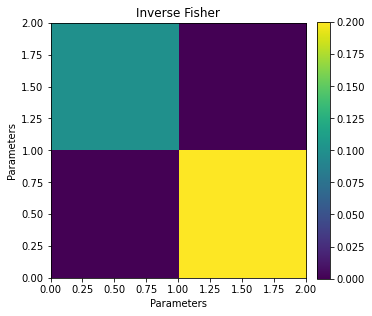

In [14]:
ga.plot_Fisher(figsize=(5, 5));

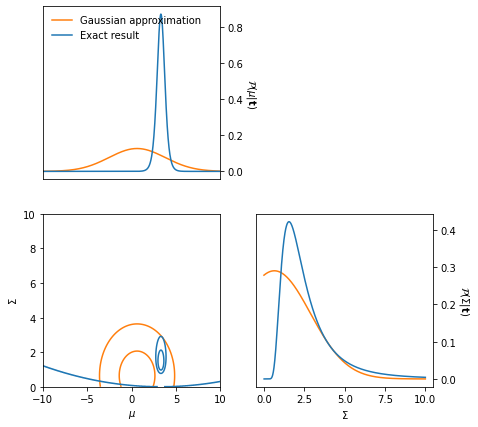

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(7, 7))
ga.plot(
    gridsize=(1000, 1000),
    ax=ax,
    color="C1",
    label="Gaussian approximation")
analytic_grid = np.reshape(ga.grid.T, (-1,) + ga.shape)[:, :, 1:]
analytic_shape = analytic_grid.shape[1:]
analytic_grid = analytic_grid.reshape((ga.n_params, -1)).T
ga.gridded_plot(
    AnalyticLikelihood(target_data).posterior(
        analytic_grid,
        analytic_shape,
        ga.prior), 
    analytic_grid, 
    analytic_shape,
    ax=ax, 
    color="C0", 
    label="Exact result");

In [3]:
generator = GenerateGaussianNoise()
data = generator.generate_data(size="full")

input_shape = data[0]["input_shape"]
n_params = data[0]["n_params"]
n_summaries = data[0]["n_summaries"]
n_s = data[0]["n_s"]
n_d = data[0]["n_d"]
θ_fid = data[0]["fiducial"]
δθ = data[0]["delta"]

fiducial = data[1]
validation_fiducial = data[2]

derivative = data[3]
validation_derivative = data[4]

print("input_shape = {}\nn_params = {}\nn_summaries = {}\n"
      "n_s = {}\nn_d = {}\nθ_fid = {}\nδθ = {}\nfiducial.shape = {}\n"
      "validation_fiducial.shape = {}\nderivative.shape = {}\n"
      "validation_derivative.shape = {}".format(
          input_shape, n_params, n_summaries, n_s, n_d, θ_fid, δθ,
          fiducial.shape, validation_fiducial.shape, derivative.shape,
          validation_derivative.shape))

input_shape = (10,)
n_params = 2
n_summaries = 2
n_s = 1000
n_d = 1000
θ_fid = [0. 1.]
δθ = [0.2 0.2]
fiducial.shape = (1000, 10)
validation_fiducial.shape = (1000, 10)
derivative.shape = (1000, 2, 2, 10)
validation_derivative.shape = (1000, 2, 2, 10)


The likelihood is given by
$$\mathcal{L} = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

We can solve this problem analytically, so it is useful to check how well the network does. There is a single sufficient statistic which describes each the mean and the variance, which can be found by finding the maximum of the probability. We find that
$$\sum_i^{n_{\bf d}}d_i = \mu\textrm{ and }\sum_i^{n_{\bf d}}(d_i-\mu)^2=n_{\bf d}\Sigma$$

We can calculate the Fisher information by taking the negative of second derivative of the likelihood taking the expectation by inserting the above relations at examining at some fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\textrm{fiducial}}.$$

|F| = 50.000000000000014


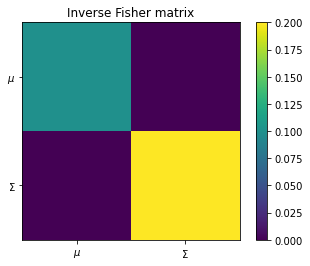

In [53]:
exact_fisher = -np.array([[-input_shape[0] / θ_fid[1], 0.], [0. , - 0.5 * input_shape[0] / θ_fid[1]**2.]])
determinant_exact_fisher = np.linalg.det(exact_fisher)
print("|F| = {}".format(determinant_exact_fisher))
plt.imshow(np.linalg.inv(exact_fisher))
plt.title("Inverse Fisher matrix")
plt.xticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.yticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.colorbar();

In [ ]:
Let us observe our _real_ data which happens to have true parameters $\mu=3$ and $\Sigma=2$

In [4]:
model = tf.keras.Sequential(
    [tf.keras.Input(shape=input_shape),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(128),
     tf.keras.layers.LeakyReLU(0.01),
     tf.keras.layers.Dense(n_summaries),
    ])
opt = tf.keras.optimizers.Adam()

In [5]:
imnn = IMNN.IMNN(n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries,
                 input_shape=input_shape, model=model, optimiser=opt, θ_fid=θ_fid, δθ=δθ,
                 fiducial_loader=fiducial, derivative_loader=derivative,
                 validation_fiducial_loader=validation_fiducial,
                 validation_derivative_loader=validation_derivative,
                 map_fn=None, check_shape=True, verbose=True, directory="model",
                 filename="model", save=True)

input shape will be (10,)
saving model to model/model
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/model/assets


In [8]:
imnn.fit(None, λ=10., ϵ=0.01, patience=50, min_iterations=100)

Using patience length of 50. Maximum number of training iterations is 10000000000.
Saving current model in model/model


Reached 50 steps without increasing val_det_F. Resetting weights to iteration 3455.



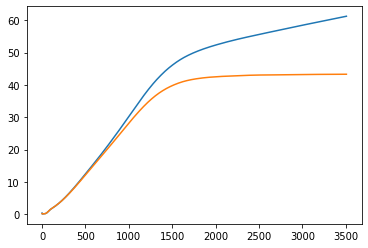

In [9]:
plt.plot(imnn.history["det_F"])
plt.plot(imnn.history["val_det_F"])

In [13]:
target_μ = 2
target_Σ = 3
target_data = np.random.normal(
    target_μ, 
    np.sqrt(target_Σ), 
    (1,) + input_shape).astype(np.float32)

θ_MLE = [1.7520932 3.5846105]
|F| = 43.29351043701172


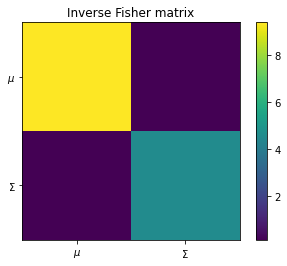

In [48]:
print("θ_MLE = {}\n|F| = {}".format(imnn.get_MLE(target_data)[0], np.linalg.det(imnn.F)))
plt.imshow(np.linalg.inv(imnn.Finv))
plt.title("Inverse Fisher matrix")
plt.xticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.yticks([0, 1], [r"$\mu$", r"$\Sigma$"])
plt.colorbar();

In [49]:
prior = priors.TruncatedGaussian(
    np.array([0., 1.]), 
    np.array([[10., 0.], [0., 10.]]), 
    np.array([-10., 0.]), 
    np.array([10., 10.]))

In [50]:
abc = ABC.ABC(
    real_data=target_data, 
    prior=prior, 
    F=imnn.F, 
    get_MLE=imnn.get_MLE, 
    simulator=lambda x : np.moveaxis(
        np.random.normal(
            x[:, 0], 
            np.sqrt(x[:, 1]), 
            input_shape + (x.shape[0],)), 
        -1, 0),
    seed=None, 
    simulator_args=None)

In [51]:
gaussian_approximation, grid = abc.gaussian_approximation(gridsize = 100)

NameError: name 'parameter_grid' is not defined

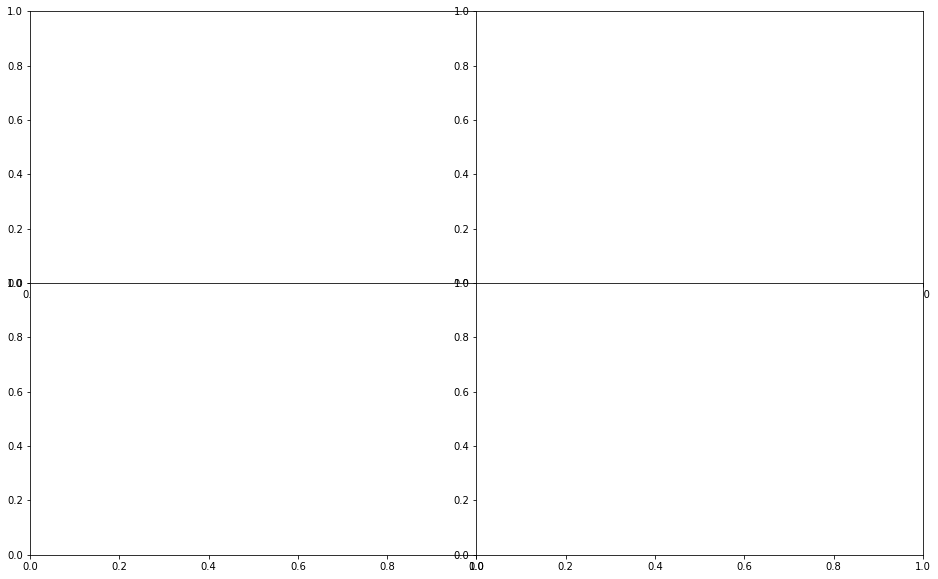

In [52]:
fig, ax = plt.subplots(2, 2, figsize = (16, 10))
plt.subplots_adjust(wspace = 0, hspace = 0)
ax[0, 0].plot(parameter_grid[0, :, 0], np.sum(analytic_posterior * (parameter_grid[0, 1, 0] - parameter_grid[0, 0, 0]), axis = 0), linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[0, 0].plot(grid[0, :, 0], np.sum(gaussian_approximation * (grid[0, 1, 0] - grid[0, 0, 0]), axis = 0), color = "C1", label = "Gaussian approximation")
ax[0, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[0, 0].legend(frameon = False)
ax[0, 0].set_xlim([-10, 10])
ax[0, 0].set_ylabel('$\\mathcal{P}(\\mu|{\\bf d})$')
ax[0, 0].set_yticks([])
ax[0, 0].set_xticks([])
ax[1, 0].set_xlabel('$\mu$');
ax[1, 0].set_ylim([0, 10])
ax[1, 0].set_ylabel('$\Sigma$')
ax[1, 0].set_xlim([-10, 10])
ax[1, 0].contour(parameter_grid[0, :, 0], parameter_grid[1, 0, :], analytic_posterior, colors = "C2")
ax[1, 0].contour(grid[0, :, 0], grid[1, 0, :], gaussian_approximation, colors = "C1")
ax[1, 0].axvline(abc.MLE[0, 0], linestyle = "dashed", color = "black", label = "Maximum likelihood estimate of mean")
ax[1, 0].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].plot(np.sum(analytic_posterior * (parameter_grid[1, 0, 1] - parameter_grid[1, 0, 0]), axis = 1), parameter_grid[1, 0, :], linewidth = 1.5, color = 'C2', label = "Analytic marginalised posterior")
ax[1, 1].plot(np.sum(gaussian_approximation * (grid[1, 0, 1] - grid[1, 0, 0]), axis = 1), grid[1, 0, :], color = "C1", label = "Gaussian approximation")
ax[1, 1].axhline(abc.MLE[0, 1], linestyle = "dotted", color = "black", label = "Maximum likelihood estimate of covariance")
ax[1, 1].legend(frameon = False)
ax[1, 1].set_ylim([0, 10])
ax[1, 1].set_xlabel('$\\mathcal{P}(\\Sigma|{\\bf d})$')
ax[1, 1].set_xticks([])
ax[1, 1].set_yticks([])
ax[0, 1].axis("off");